# Orbit Definition 

## Authors

Lots of parts are directly from the orekit documentation on [orbits](https://www.orekit.org/site-orekit-latest/architecture/orbits.html), with some updates, simplifications and Pythonification by Petrus Hyvönen, SSC

## Learning Goals
* *What is an orbit defintion*: What is the background
* *How do I speficy my satellite*: How is it implemented in Orekit

## Keywords
orekit, orbits

## Further documentation
- [Orekit architecture description](https://www.orekit.org/site-orekit-latest/architecture/orbits.html)
- [org.orekit.orbit package API documentation](https://www.orekit.org/site-orekit-latest/apidocs/org/orekit/orbits/package-summary.html)

In [6]:
%matplotlib inline

from math import radians, degrees

Initialize orkit and bring up the python-java interface

In [7]:
import orekit_jpype
vm = orekit_jpype.initVM()

JVM already started, resuming on started JVM


Now set up the pointer to the orekit-data.zip file, using one of the helper files. The file should be in current directory if not specified otherwise.

In [8]:
from orekit_jpype.pyhelpers import setup_orekit_data, absolutedate_to_datetime
setup_orekit_data()

Now we are set up to import and use objects from the orekit library. Packages can be imported as they were native Python packages

# Orbit definition

In order to specify the state of a satellite that is to be propagated or analyzed, one needs to specify the state of the object, which can be done in several ways. Which way to select will depend partly on the match with other documentation, but also depeding on the kind of orbit to be specified.

## Orbit Representations 

### Classic Elliptical Keplerian Orbit
This orbit is a traditional Keplerian orbit representation with the parameters:

- a : semi-major axis (m)
- e : eccentricity (any value of e is supported, i.e. both elliptical and hyperbolic orbits can be used)
- i : inclination (radians)
- ω : perigee argument (radians)
- Ω : right ascension of the ascending node (radians)
- v, M or E : Anomaly, can be chosen among true anomaly, mean anomaly or eccentric anomaly (radians)

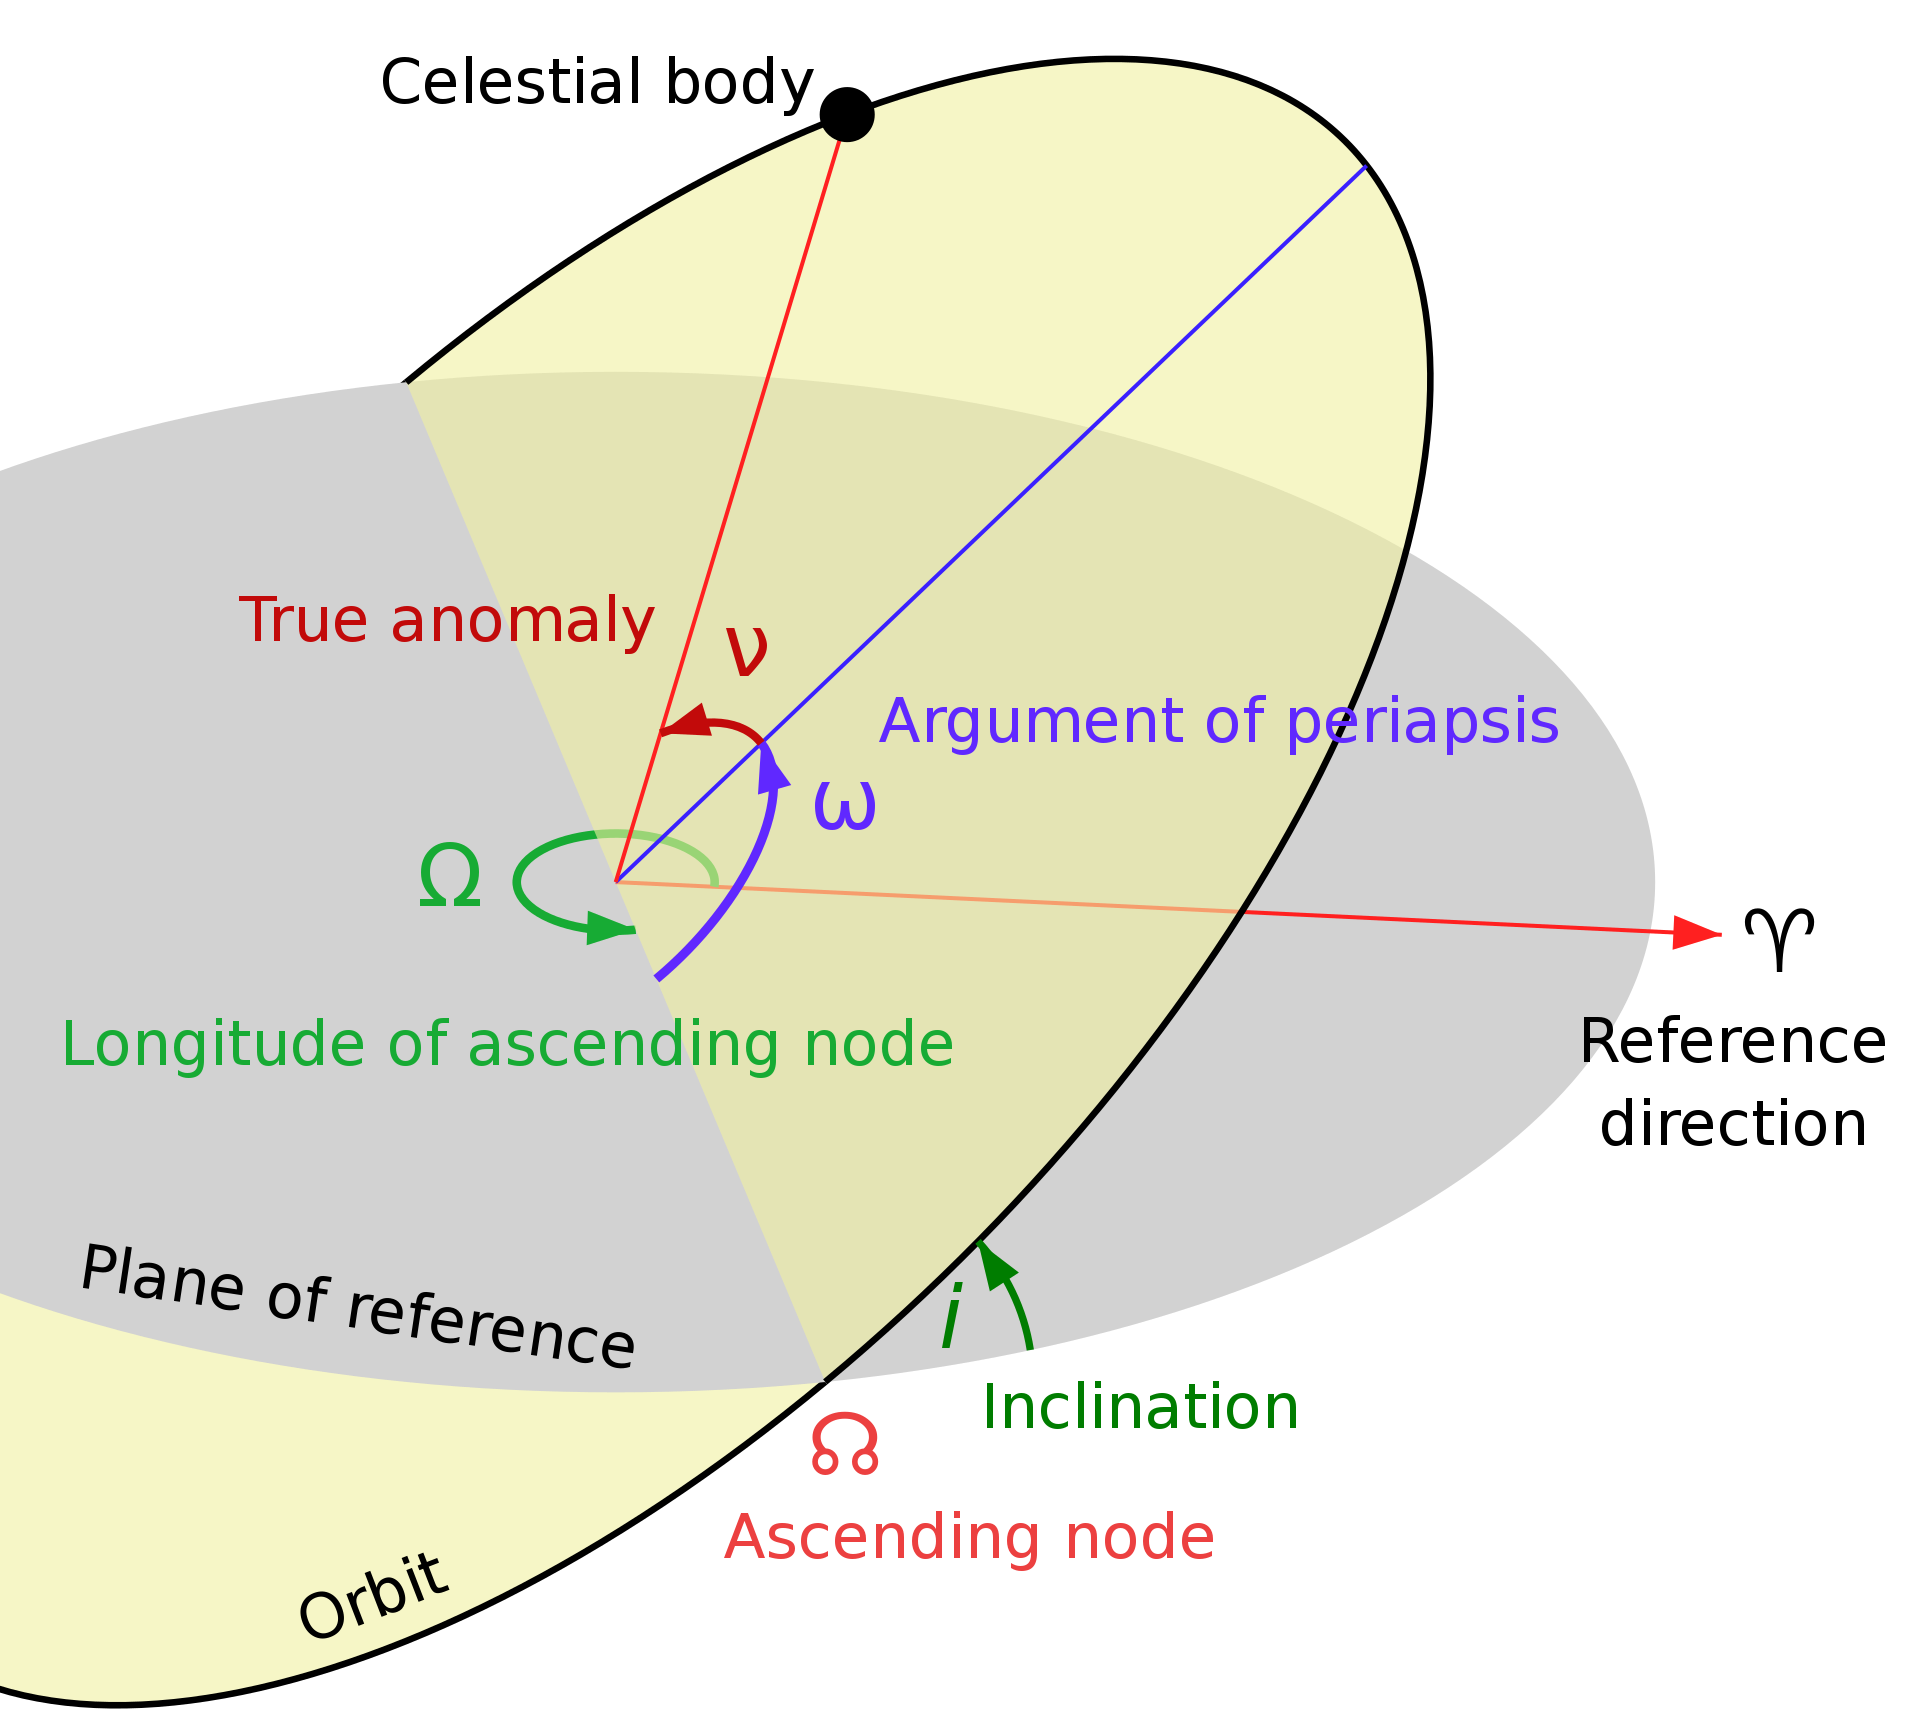
By Lasunncty at the English Wikipedia, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=8971052

When orbit is either equatorial or circular, some Keplerian elements (more precisely ω and Ω) become ambiguous so this type of definition should not be used for such orbits. For this reason, equinoctial orbits or circular orbits are the recommended way to represent orbits.

[Orekit documentation of the KeplerianObject](https://www.orekit.org/site-orekit-latest/apidocs/org/orekit/orbits/KeplerianOrbit.html)

[Wikipedia on Keplerian Orbital Elements](https://en.wikipedia.org/wiki/Orbital_elements#Keplerian)

In [9]:
from org.orekit.orbits import KeplerianOrbit, PositionAngleType, OrbitType
from org.orekit.frames import FramesFactory
from org.orekit.utils import Constants
from org.orekit.time import AbsoluteDate

In [10]:
k_orbit = KeplerianOrbit(24464560.0, # Semimajor Axis (m)
                0.7311,    # Eccentricity
                0.122138,  # Inclination (radians)
                3.10686,   # Perigee argument (radians)
                1.00681,   # Right ascension of ascending node (radians)
                0.048363,  # Anomaly (rad/s)
                PositionAngleType.MEAN,  # Sets which type of anomaly we use
                FramesFactory.getEME2000(), # The frame in which the parameters are defined (must be a pseudo-inertial frame)
                AbsoluteDate.J2000_EPOCH,   # Sets the date of the orbital parameters
                Constants.WGS84_EARTH_MU)   # Sets the central attraction coefficient (m³/s²)

In [11]:
k_orbit

<KeplerianOrbit: Keplerian parameters: {a: 2.446456E7; e: 0.7311; i: 6.997991918168848; pa: 178.00996553801494; raan: 57.68596377156641; v: 25.421887733782746;}>

In [12]:
k_orbit.getType()

<: KEPLERIAN>

### Circular orbit
This orbit type is used to represent a circular, or almost circular orbit. The classical Keplerian orbit is not well suitable for that as the definition of perigee is not well defined. 

Montenbruck in Satellite Orbits is stating : _"While there is no inherent difficulty in calculating position and velocity from
known keplerian orbital elements with e and i close to zero, the reverse task may cause practical and numerical problems. These problems are due to singularities arising from
the definition of some of the classical orbital elements. The argument of perigee, for example, is not a meaningful orbital element for small eccentricities, since the
perigee itself is not well defined for an almost circular orbit. Small changes of the
orbit may change the perigee location by a large amount, and small numerical errors
may lead to enhanced errors in the computation of ω since the equation for E
becomes almost singular in this case. Similar considerations apply to small inclinations
where the line of nodes is no longer well defined and where the equations
for Ω become singular. Several attempts have therefore been made to substitute
other parameters for the classical Keplerian elements. These elements are usually
referred to as non-singular, regular or equinoctial elements" (pg 30)_ 

The definition of this orbit is based on the concept of Eccentricity Vector. This vector is in the orbital plane, pointing towards the reference direction for the perigee with a magnitude of e.

The parameters for the circular orbit are:

- a : semi-major axis (m)
- ex : X component of eccentricity vector : e × cos(ω)
- ey : Y component of eccentricity vector : e × sin(ω)
- i : inclination (rad)
- Ω : right ascension of the ascending node (rad)
- αv, αM or αE (rad) : respectively (ω + v), (ω + M) or (ω + E)


When orbit is equatorial, neither the Keplerian or the circular parameters can be defined unambiguously, then the equinoctial orbits is the recommended way to represent orbits.

[Orekit documentation of the CircularOrbit](https://www.orekit.org/site-orekit-latest/apidocs/org/orekit/orbits/CircularOrbit.html)

### Equinoctial orbit

The equinoctial orbit is another non-signular orbit that is used to prepresent orbits that are almost circular and equatorial as these are not well defined in other representations. 

The parameters are:

- a : semi-major axis (m)
- ex = e × cos(ω + Ω)
- ey = e × sin(ω + Ω)
- hx = tan(i/2) cos(Ω)
- hy = tan(i/2) sin(Ω)
- λv, λM or λE (rad) : respectively true longitude argument (ω + Ω + v) mean longitude argument (ω + Ω + M) or eccentric longitude argument (ω + Ω + E)

See also Montenbruck, pg 30. or Vallado pg 142.

[Orekit documentation on Equinoctial Orbit](https://www.orekit.org/site-orekit-latest/apidocs/org/orekit/orbits/EquinoctialOrbit.html)

### Cartesian orbit / State vector

An orbit can also be based on a position and velocity pair in a specified frame.

The parameters are then:
- (X, Y, Z) (m) : position vector of the point in given frame
- (Vx, Vy, Vz) (m/s) : velocity vector of the point in given frame


### Two-line Elements

Two line elements are not a pure orbit representation, as they are a combination between an orbital state and a specific propagation model. The state specified in the TLE is only meaningful with respect to the SGP3/SDP4 propagation model and cannot be used as in other models.

See separate notebook on TLE elements.

### Conversion of orbits 

It is possible to convert between different orbit types. Note that there are some orbits that are not well represented in other forms, and needs to be taken into manual consideration.

In [13]:
OrbitType.CARTESIAN.convertType(k_orbit)

<CartesianOrbit: Cartesian parameters: {P(-1076225.3246796934, -6765896.36432772, -332308.78335037566), V(9356.857420553719, -3312.3476332062446, -1188.01573330242)}>

In [14]:
OrbitType.EQUINOCTIAL.convertType(k_orbit)

<EquinoctialOrbit: equinoctial parameters: {a: 2.446456E7; ex: -0.4120368028876257; ey: -0.6039311906717055; hx: 0.032685651234488015; hy: 0.051675555094569635; lv: 261.11781704336414;}>

In [15]:
OrbitType.CIRCULAR.convertType(k_orbit)

<CircularOrbit: circular parameters: {a: 2.446456E7, ex: -0.7306590604464844, ey: 0.025387937833951824, i: 6.997991918168848, raan: 57.68596377156641, alphaV: 203.4318532717977;}>

## A note on defining frames 

Orbits also include a reference to a date and a defining frame. 

Only pseudo-inertial frames can be used to define orbits, as Newtonian mechanics should apply within the context of the frame. Including frames allows transparent conversions to any other frames at given date, without having to externally preserve a mapping between orbits and their frame: it is already done. 

As an example, getting the position and velocity of a satellite given by a circular orbit in a ground station frame is simply a matter of calling orbit.getPVCoordinates(stationFrame), regardless of the pseudo-inertial frame in which the orbit is defined (EME2000, GCRF …).

In [16]:
from org.orekit.frames import TopocentricFrame, FramesFactory
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint
from org.orekit.utils import IERSConventions

In [17]:
earthFrame = FramesFactory.getITRF(IERSConventions.IERS_2010, True)
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                                       Constants.WGS84_EARTH_FLATTENING,
                                       earthFrame)

In [18]:
longitude = radians(21.063)
latitude  = radians(67.878)
altitude  = 341.0
station_point = GeodeticPoint(latitude, longitude, altitude)
station_frame = TopocentricFrame(earth, station_point, "Esrange")

The following then obtains the state for the satellite in the station frame:

In [19]:
k_orbit.getPVCoordinates(station_frame)

<TimeStampedPVCoordinates: {2000-01-01T11:58:55.816, P(-4430688.814101731, -4950845.186894559, -4699999.637262113), V(5898.915766042543, -7268.899236563421, 1672.2669437202935), A(4.37551135902497, 5.311239823172293, -1.716229899577791)}>

# Mean and Osculating Elements

In some cases it is important to differ between what is called mean and osculating elements. 

The osculating elements are defined at any instant in time by the position and velocity vectors. The element for this is the orbit that a satellite will have _if there are no other forces than the gravitational Keplerian force_. This means that for a satellite that has some perturbations, each point on the orbit has a corresponding osculating element. Osculating elements are the true time-varying orbital elements, and they include periodic (long- and shortperidic) and secular effects. 

Mean elements in contrast are averaged over some period of time so they are not varying as frequent and is not used for describing short term variations. The time period over which and how the mean is calculated needs to be specified to have full understanding. Mean elements are useful for long-time mission planning.
